In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from myfun.try_gpu import *
from myfun.setup_seed import *
from myfun.create_dataset import *
from myfun.evaluation import *
from model.rnn import RNN

np.set_printoptions(threshold=np.inf)

In [2]:
data = pd.read_csv('dataset/B0005.csv')
ts = data['Capacity'].tolist()
Cy = data['Cycles'].tolist()

In [3]:
look_back=16
dataX, dataY = create_dataset(ts, look_back)

In [4]:
train_x = torch.from_numpy(dataX[:15])
train_y = torch.from_numpy(dataY[:15])
print(train_x.shape)
print(train_y.shape)

torch.Size([15, 1, 16])
torch.Size([15])


In [5]:
def train(hidden_size=128, look_back=16, lr=0.001, EPOCH=1000, seed=0, train_size=15, mode = 'RNN'):
    dataX, dataY = create_dataset(ts, look_back)

    test_size = len(dataX) - train_size
    train_x = torch.from_numpy(dataX[:train_size])
    train_y = torch.from_numpy(dataY[:train_size])
    test_x = torch.from_numpy(dataX[train_size:])
    test_y = torch.from_numpy(dataY[train_size:])
    print(train_x.shape)

    setup_seed(seed)
    model = RNN(input_size=look_back, hidden_dim=hidden_size, mode=mode)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    score_list = []
    t_x = test_x.clone()
    loss_list = [0]
    mae, mse, rmse, r2 = 1, 1, 1, 1
    score_, score = 1,1
    for epoch in range(EPOCH):
        model.train()
        train_x = train_x.to(torch.float32).to(device)
        train_y = train_y.to(torch.float32).reshape(train_size, -1).to(device)
    
        out = model(train_x)
        loss = criterion(out, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1)%100 == 0:     #每100次重新预测一次
            model.eval()
            with torch.no_grad():
                t_x = test_x.clone()   
                t_x = t_x.to(torch.float32).to(device)
                pred_test = model(t_x) # 测试集的预测结果
                pred_test = pred_test.view(-1).cpu().detach().numpy()
            loss_list.append(loss)
            mae, mse, rmse, r2 = evaluation(test_y=test_y, pred_test=pred_test)

            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | MSE:{:<6.4f} | RMSE:{:<6.4f} | R2:{:<6.3f}'.format(epoch+1, loss, mae, mse, rmse, r2))
        
        score = [mae, mse, rmse, r2]
        # if (loss < 1e-3) and (score_[0] < score[0]) and (score_[2] < score[2]):
        #     break
        score_ = score.copy()
    score_list.append(score_)
    return score_list, pred_test

# 模型训练

## RNN

### 30

In [6]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=2000
seed=0
train_size=15
mode='RNN'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:1
torch.Size([15, 1, 16])
epoch:100 | loss:0.0003 | MAE:0.1256 | MSE:0.0181 | RMSE:0.1344 | R2:0.321 
epoch:200 | loss:0.0003 | MAE:0.1213 | MSE:0.0170 | RMSE:0.1303 | R2:0.361 
epoch:300 | loss:0.0003 | MAE:0.1213 | MSE:0.0170 | RMSE:0.1304 | R2:0.361 
epoch:400 | loss:0.0003 | MAE:0.1214 | MSE:0.0170 | RMSE:0.1305 | R2:0.360 
epoch:500 | loss:0.0003 | MAE:0.1215 | MSE:0.0171 | RMSE:0.1306 | R2:0.359 
epoch:600 | loss:0.0003 | MAE:0.1216 | MSE:0.0171 | RMSE:0.1307 | R2:0.358 
epoch:700 | loss:0.0003 | MAE:0.1217 | MSE:0.0171 | RMSE:0.1308 | R2:0.356 
epoch:800 | loss:0.0003 | MAE:0.1218 | MSE:0.0172 | RMSE:0.1310 | R2:0.355 
epoch:900 | loss:0.0003 | MAE:0.1219 | MSE:0.0172 | RMSE:0.1311 | R2:0.354 
epoch:1000 | loss:0.0003 | MAE:0.1221 | MSE:0.0172 | RMSE:0.1313 | R2:0.352 
epoch:1100 | loss:0.0003 | MAE:0.1222 | MSE:0.0173 | RMSE:0.1315 | R2:0.350 
epoch:1200 | loss:0.0003 | MAE:0.1224 | MSE:0.0173 | RMSE:0.1317 | R2:0.348 
epoch:1300 | loss:0.0003 | MAE:0.1226 | MSE:

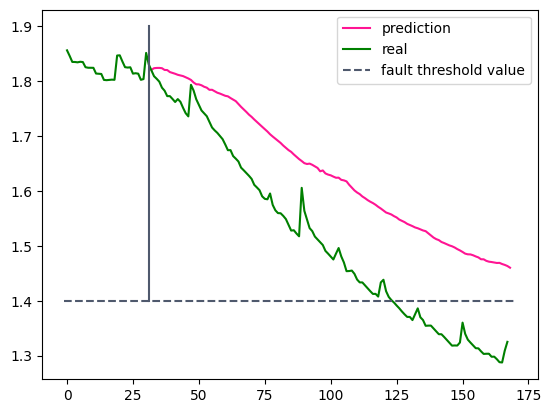

In [26]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [27]:
txt = pred_test.tolist()
txt

[1.8208998441696167,
 1.8239367008209229,
 1.8244073390960693,
 1.8244701623916626,
 1.8239322900772095,
 1.820753574371338,
 1.8205488920211792,
 1.8168894052505493,
 1.8153287172317505,
 1.8137739896774292,
 1.8119009733200073,
 1.8106917142868042,
 1.8095484972000122,
 1.8073229789733887,
 1.805211067199707,
 1.8025453090667725,
 1.7978485822677612,
 1.794622540473938,
 1.7944144010543823,
 1.7927964925765991,
 1.7901115417480469,
 1.78842294216156,
 1.7845127582550049,
 1.784594178199768,
 1.7819169759750366,
 1.7792551517486572,
 1.7776468992233276,
 1.7756975889205933,
 1.7736421823501587,
 1.772634744644165,
 1.7695285081863403,
 1.7667118310928345,
 1.763855218887329,
 1.7586756944656372,
 1.753466248512268,
 1.7488192319869995,
 1.7442070245742798,
 1.7392302751541138,
 1.7351981401443481,
 1.7304216623306274,
 1.7260888814926147,
 1.7220264673233032,
 1.7171759605407715,
 1.712809681892395,
 1.708462119102478,
 1.7034837007522583,
 1.6993640661239624,
 1.6955441236495972,
 1.

### 60

In [8]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=2400
seed=0
train_size=45
mode='RNN'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:1
torch.Size([45, 1, 16])
epoch:100 | loss:0.0009 | MAE:0.1194 | MSE:0.0149 | RMSE:0.1221 | R2:-0.184
epoch:200 | loss:0.0009 | MAE:0.1145 | MSE:0.0138 | RMSE:0.1173 | R2:-0.093
epoch:300 | loss:0.0009 | MAE:0.1127 | MSE:0.0133 | RMSE:0.1155 | R2:-0.058
epoch:400 | loss:0.0009 | MAE:0.1106 | MSE:0.0128 | RMSE:0.1133 | R2:-0.019
epoch:500 | loss:0.0009 | MAE:0.1081 | MSE:0.0123 | RMSE:0.1107 | R2:0.026 
epoch:600 | loss:0.0008 | MAE:0.1053 | MSE:0.0116 | RMSE:0.1079 | R2:0.076 
epoch:700 | loss:0.0008 | MAE:0.1023 | MSE:0.0110 | RMSE:0.1047 | R2:0.129 
epoch:800 | loss:0.0008 | MAE:0.0989 | MSE:0.0103 | RMSE:0.1012 | R2:0.186 
epoch:900 | loss:0.0008 | MAE:0.0952 | MSE:0.0095 | RMSE:0.0975 | R2:0.246 
epoch:1000 | loss:0.0008 | MAE:0.0913 | MSE:0.0087 | RMSE:0.0934 | R2:0.307 
epoch:1100 | loss:0.0007 | MAE:0.0871 | MSE:0.0079 | RMSE:0.0890 | R2:0.371 
epoch:1200 | loss:0.0007 | MAE:0.0826 | MSE:0.0071 | RMSE:0.0843 | R2:0.435 
epoch:1300 | loss:0.0007 | MAE:0.0778 | MSE:

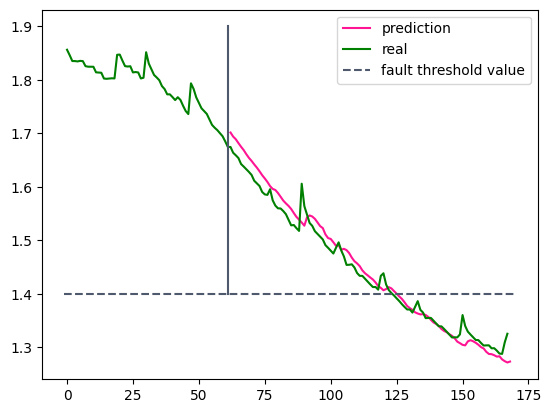

In [31]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [32]:
txt = pred_test.tolist()
txt

[1.7016117572784424,
 1.6940211057662964,
 1.6890207529067993,
 1.681819200515747,
 1.674942970275879,
 1.6686807870864868,
 1.660975694656372,
 1.654049038887024,
 1.6483603715896606,
 1.6418765783309937,
 1.635832667350769,
 1.6290990114212036,
 1.621824860572815,
 1.6156436204910278,
 1.6090863943099976,
 1.6013401746749878,
 1.5960603952407837,
 1.5940665006637573,
 1.588380217552185,
 1.5814120769500732,
 1.5742419958114624,
 1.568999171257019,
 1.5642826557159424,
 1.5585724115371704,
 1.5509560108184814,
 1.5437402725219727,
 1.5385664701461792,
 1.533185601234436,
 1.5272883176803589,
 1.5427242517471313,
 1.5464657545089722,
 1.5444666147232056,
 1.5400673151016235,
 1.5333247184753418,
 1.5264437198638916,
 1.5227266550064087,
 1.5108660459518433,
 1.5041314363479614,
 1.502493143081665,
 1.4963032007217407,
 1.4896432161331177,
 1.4909087419509888,
 1.4822043180465698,
 1.4840418100357056,
 1.4815301895141602,
 1.4759693145751953,
 1.4675155878067017,
 1.460801362991333,
 1.

### 90

In [33]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=900
seed=0
train_size=75
mode='RNN'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([75, 1, 16])
epoch:100 | loss:0.0024 | MAE:0.0963 | MSE:0.0096 | RMSE:0.0978 | R2:-0.910
epoch:200 | loss:0.0022 | MAE:0.0858 | MSE:0.0076 | RMSE:0.0872 | R2:-0.519
epoch:300 | loss:0.0019 | MAE:0.0754 | MSE:0.0059 | RMSE:0.0767 | R2:-0.177
epoch:400 | loss:0.0017 | MAE:0.0637 | MSE:0.0042 | RMSE:0.0649 | R2:0.158 
epoch:500 | loss:0.0014 | MAE:0.0509 | MSE:0.0027 | RMSE:0.0523 | R2:0.454 
epoch:600 | loss:0.0012 | MAE:0.0378 | MSE:0.0016 | RMSE:0.0394 | R2:0.690 
epoch:700 | loss:0.0010 | MAE:0.0254 | MSE:0.0007 | RMSE:0.0270 | R2:0.854 
epoch:800 | loss:0.0008 | MAE:0.0150 | MSE:0.0003 | RMSE:0.0173 | R2:0.940 
epoch:900 | loss:0.0007 | MAE:0.0113 | MSE:0.0002 | RMSE:0.0148 | R2:0.956 


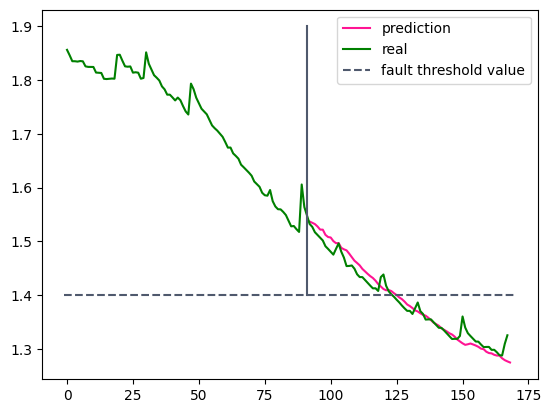

In [34]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [35]:
txt = pred_test.tolist()
txt

[1.5368682146072388,
 1.5344765186309814,
 1.5320957899093628,
 1.5275744199752808,
 1.5217955112457275,
 1.5217043161392212,
 1.512036919593811,
 1.5080331563949585,
 1.507067084312439,
 1.5004441738128662,
 1.4965442419052124,
 1.4967825412750244,
 1.4878634214401245,
 1.485164761543274,
 1.48316490650177,
 1.4771257638931274,
 1.470486044883728,
 1.4639431238174438,
 1.4597049951553345,
 1.4551767110824585,
 1.4486576318740845,
 1.4440878629684448,
 1.439427375793457,
 1.4351768493652344,
 1.4316774606704712,
 1.4266469478607178,
 1.4204134941101074,
 1.4158765077590942,
 1.4112290143966675,
 1.4088749885559082,
 1.4093049764633179,
 1.4073420763015747,
 1.4033098220825195,
 1.3998717069625854,
 1.395516276359558,
 1.392330527305603,
 1.3877910375595093,
 1.382386326789856,
 1.3794430494308472,
 1.3757504224777222,
 1.3714381456375122,
 1.3694193363189697,
 1.365944743156433,
 1.3631385564804077,
 1.3615678548812866,
 1.3577972650527954,
 1.353371262550354,
 1.3485950231552124,
 1.3

## GRU

### 30

In [38]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=200
seed=0
train_size=15
mode='GRU'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([15, 1, 16])
epoch:100 | loss:0.0004 | MAE:0.1394 | MSE:0.0224 | RMSE:0.1497 | R2:0.157 
epoch:200 | loss:0.0003 | MAE:0.1337 | MSE:0.0209 | RMSE:0.1445 | R2:0.214 


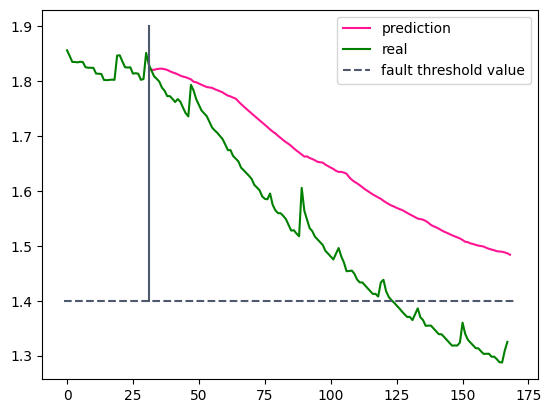

In [39]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [40]:
txt = pred_test.tolist()
txt

[1.8210774660110474,
 1.8209176063537598,
 1.8223284482955933,
 1.822910189628601,
 1.8231394290924072,
 1.8221343755722046,
 1.820778727531433,
 1.8183437585830688,
 1.8163443803787231,
 1.8147860765457153,
 1.8127752542495728,
 1.8102613687515259,
 1.8086299896240234,
 1.8074606657028198,
 1.805629849433899,
 1.8036253452301025,
 1.7992936372756958,
 1.7982840538024902,
 1.7959353923797607,
 1.7936900854110718,
 1.791591763496399,
 1.7895225286483765,
 1.7888257503509521,
 1.7881046533584595,
 1.7857475280761719,
 1.7837028503417969,
 1.7818713188171387,
 1.7798594236373901,
 1.7766984701156616,
 1.773990511894226,
 1.772445797920227,
 1.770309329032898,
 1.7683948278427124,
 1.7633122205734253,
 1.7585316896438599,
 1.7541863918304443,
 1.749727487564087,
 1.7456316947937012,
 1.7414323091506958,
 1.737087607383728,
 1.7330899238586426,
 1.7289930582046509,
 1.7250062227249146,
 1.7208850383758545,
 1.7165145874023438,
 1.712386965751648,
 1.7083053588867188,
 1.7051196098327637,
 1

### 60

In [43]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=2300
seed=0
train_size=45
mode='GRU'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([45, 1, 16])
epoch:100 | loss:0.0010 | MAE:0.1354 | MSE:0.0193 | RMSE:0.1388 | R2:-0.530
epoch:200 | loss:0.0010 | MAE:0.1288 | MSE:0.0175 | RMSE:0.1324 | R2:-0.391
epoch:300 | loss:0.0009 | MAE:0.1264 | MSE:0.0169 | RMSE:0.1298 | R2:-0.339
epoch:400 | loss:0.0009 | MAE:0.1236 | MSE:0.0161 | RMSE:0.1269 | R2:-0.278
epoch:500 | loss:0.0009 | MAE:0.1203 | MSE:0.0152 | RMSE:0.1234 | R2:-0.209
epoch:600 | loss:0.0009 | MAE:0.1165 | MSE:0.0143 | RMSE:0.1195 | R2:-0.134
epoch:700 | loss:0.0009 | MAE:0.1124 | MSE:0.0133 | RMSE:0.1152 | R2:-0.054
epoch:800 | loss:0.0009 | MAE:0.1079 | MSE:0.0122 | RMSE:0.1105 | R2:0.030 
epoch:900 | loss:0.0008 | MAE:0.1030 | MSE:0.0111 | RMSE:0.1055 | R2:0.116 
epoch:1000 | loss:0.0008 | MAE:0.0978 | MSE:0.0100 | RMSE:0.1001 | R2:0.205 
epoch:1100 | loss:0.0008 | MAE:0.0923 | MSE:0.0089 | RMSE:0.0943 | R2:0.293 
epoch:1200 | loss:0.0008 | MAE:0.0865 | MSE:0.0078 | RMSE:0.0883 | R2:0.381 
epoch:1300 | loss:0.0007 | MAE:0.0803 | MSE:

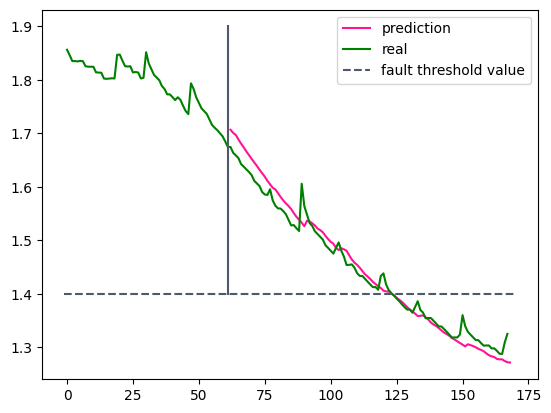

In [44]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [45]:
txt = pred_test.tolist()
txt

[1.7068865299224854,
 1.701002597808838,
 1.697095513343811,
 1.688779592514038,
 1.6809196472167969,
 1.6740361452102661,
 1.6663641929626465,
 1.65945565700531,
 1.6525235176086426,
 1.6457126140594482,
 1.639278531074524,
 1.632156252861023,
 1.6256974935531616,
 1.618887186050415,
 1.611340045928955,
 1.6047346591949463,
 1.5983374118804932,
 1.5953030586242676,
 1.5883510112762451,
 1.5811586380004883,
 1.5747061967849731,
 1.5690832138061523,
 1.5642592906951904,
 1.5584074258804321,
 1.5508778095245361,
 1.5440115928649902,
 1.5387834310531616,
 1.5328831672668457,
 1.5264023542404175,
 1.536628007888794,
 1.535372257232666,
 1.5319232940673828,
 1.5278594493865967,
 1.5220797061920166,
 1.5191895961761475,
 1.515089988708496,
 1.5084291696548462,
 1.502476453781128,
 1.4971916675567627,
 1.493759036064148,
 1.4859788417816162,
 1.4818103313446045,
 1.485177755355835,
 1.4833214282989502,
 1.4804729223251343,
 1.472071886062622,
 1.4642456769943237,
 1.458329677581787,
 1.454240

### 90

In [48]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=800
seed=0
train_size=75
mode='GRU'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([75, 1, 16])
epoch:100 | loss:0.0028 | MAE:0.1110 | MSE:0.0127 | RMSE:0.1126 | R2:-1.534
epoch:200 | loss:0.0024 | MAE:0.0969 | MSE:0.0097 | RMSE:0.0984 | R2:-0.936
epoch:300 | loss:0.0021 | MAE:0.0827 | MSE:0.0071 | RMSE:0.0841 | R2:-0.413
epoch:400 | loss:0.0017 | MAE:0.0671 | MSE:0.0047 | RMSE:0.0684 | R2:0.066 
epoch:500 | loss:0.0014 | MAE:0.0510 | MSE:0.0027 | RMSE:0.0524 | R2:0.452 
epoch:600 | loss:0.0012 | MAE:0.0353 | MSE:0.0014 | RMSE:0.0370 | R2:0.727 
epoch:700 | loss:0.0009 | MAE:0.0217 | MSE:0.0005 | RMSE:0.0234 | R2:0.891 
epoch:800 | loss:0.0008 | MAE:0.0117 | MSE:0.0002 | RMSE:0.0144 | R2:0.959 


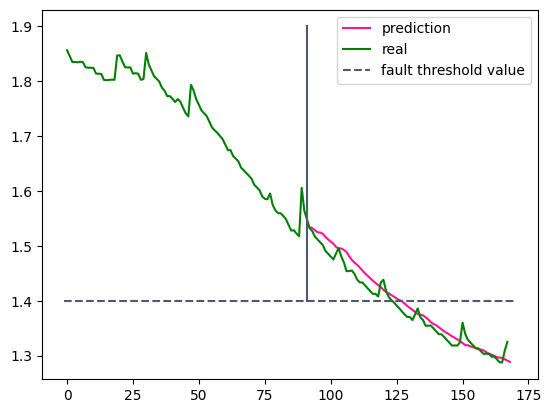

In [49]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [50]:
txt = pred_test.tolist()
txt

[1.5341514348983765,
 1.5324492454528809,
 1.5286047458648682,
 1.5248318910598755,
 1.5242133140563965,
 1.522181749343872,
 1.5163991451263428,
 1.5119922161102295,
 1.5077956914901733,
 1.504014492034912,
 1.4981663227081299,
 1.4951101541519165,
 1.4952934980392456,
 1.4927245378494263,
 1.4889575242996216,
 1.481215000152588,
 1.4745012521743774,
 1.4695652723312378,
 1.4656845331192017,
 1.4608283042907715,
 1.4552141427993774,
 1.4498707056045532,
 1.4454630613327026,
 1.4409998655319214,
 1.4364441633224487,
 1.4323629140853882,
 1.4285186529159546,
 1.4248104095458984,
 1.4197267293930054,
 1.4161635637283325,
 1.4134081602096558,
 1.410251259803772,
 1.4075418710708618,
 1.4040518999099731,
 1.4014030694961548,
 1.3989676237106323,
 1.3949488401412964,
 1.3906697034835815,
 1.3868874311447144,
 1.383335828781128,
 1.3795408010482788,
 1.375667691230774,
 1.3745840787887573,
 1.3732854127883911,
 1.369903326034546,
 1.3658877611160278,
 1.3607782125473022,
 1.3576319217681885,

## LSTM

### 30

In [53]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=100
seed=0
train_size=15
mode='LSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([15, 1, 16])
epoch:100 | loss:0.0003 | MAE:0.1288 | MSE:0.0196 | RMSE:0.1400 | R2:0.264 


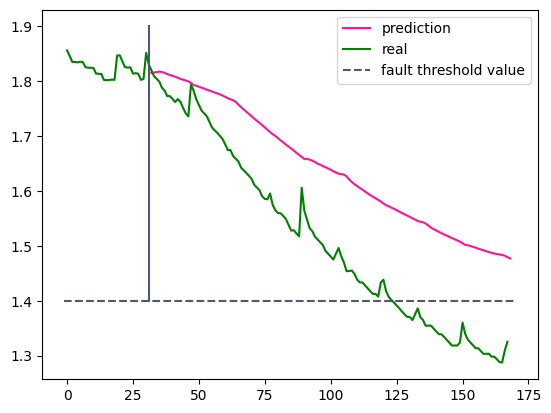

In [54]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [55]:
txt = pred_test.tolist()
txt

[1.815259337425232,
 1.81605064868927,
 1.817044734954834,
 1.8176933526992798,
 1.8171086311340332,
 1.8155354261398315,
 1.8132082223892212,
 1.811665654182434,
 1.810002088546753,
 1.8083620071411133,
 1.8063759803771973,
 1.804532527923584,
 1.8029853105545044,
 1.80161452293396,
 1.8000158071517944,
 1.7971279621124268,
 1.7930759191513062,
 1.7918241024017334,
 1.7901268005371094,
 1.7884093523025513,
 1.7868382930755615,
 1.7847720384597778,
 1.7833014726638794,
 1.781365990638733,
 1.7797088623046875,
 1.7780009508132935,
 1.7763081789016724,
 1.774062156677246,
 1.7715753316879272,
 1.76920747756958,
 1.7673588991165161,
 1.765401840209961,
 1.762427568435669,
 1.7574772834777832,
 1.7529083490371704,
 1.7487201690673828,
 1.744439959526062,
 1.7403894662857056,
 1.7361260652542114,
 1.7319988012313843,
 1.728095531463623,
 1.7240718603134155,
 1.7200876474380493,
 1.7160109281539917,
 1.7116304636001587,
 1.707472801208496,
 1.7036019563674927,
 1.7003918886184692,
 1.6963783

### 60

In [57]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=2200
seed=0
train_size=45
mode='LSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([45, 1, 16])
epoch:100 | loss:0.0010 | MAE:0.1246 | MSE:0.0165 | RMSE:0.1283 | R2:-0.307
epoch:200 | loss:0.0010 | MAE:0.1294 | MSE:0.0176 | RMSE:0.1328 | R2:-0.401
epoch:300 | loss:0.0009 | MAE:0.1274 | MSE:0.0171 | RMSE:0.1307 | R2:-0.357
epoch:400 | loss:0.0009 | MAE:0.1249 | MSE:0.0164 | RMSE:0.1281 | R2:-0.302
epoch:500 | loss:0.0009 | MAE:0.1219 | MSE:0.0156 | RMSE:0.1250 | R2:-0.240
epoch:600 | loss:0.0009 | MAE:0.1185 | MSE:0.0147 | RMSE:0.1214 | R2:-0.171
epoch:700 | loss:0.0009 | MAE:0.1147 | MSE:0.0138 | RMSE:0.1174 | R2:-0.095
epoch:800 | loss:0.0009 | MAE:0.1105 | MSE:0.0128 | RMSE:0.1130 | R2:-0.014
epoch:900 | loss:0.0009 | MAE:0.1058 | MSE:0.0117 | RMSE:0.1081 | R2:0.072 
epoch:1000 | loss:0.0008 | MAE:0.1006 | MSE:0.0106 | RMSE:0.1028 | R2:0.161 
epoch:1100 | loss:0.0008 | MAE:0.0950 | MSE:0.0094 | RMSE:0.0970 | R2:0.253 
epoch:1200 | loss:0.0008 | MAE:0.0890 | MSE:0.0082 | RMSE:0.0908 | R2:0.346 
epoch:1300 | loss:0.0008 | MAE:0.0826 | MSE:

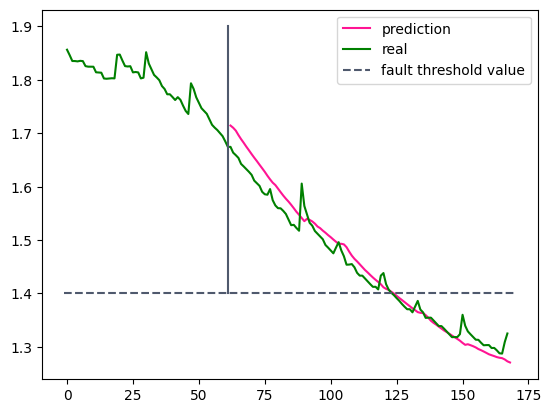

In [58]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [59]:
txt = pred_test.tolist()
txt

[1.7144465446472168,
 1.7103767395019531,
 1.7049751281738281,
 1.6966743469238281,
 1.6890759468078613,
 1.6821625232696533,
 1.6748807430267334,
 1.668062686920166,
 1.661015510559082,
 1.654266119003296,
 1.6478664875030518,
 1.6410832405090332,
 1.634491205215454,
 1.6277966499328613,
 1.6204549074172974,
 1.6137197017669678,
 1.6075246334075928,
 1.6030577421188354,
 1.5964736938476562,
 1.5897916555404663,
 1.5833604335784912,
 1.577462911605835,
 1.5720442533493042,
 1.5660700798034668,
 1.5596588850021362,
 1.5529680252075195,
 1.547400951385498,
 1.5413076877593994,
 1.535409927368164,
 1.5397651195526123,
 1.5377933979034424,
 1.5349617004394531,
 1.530771017074585,
 1.5254220962524414,
 1.522266149520874,
 1.5177000761032104,
 1.5137429237365723,
 1.509343147277832,
 1.505412220954895,
 1.5010113716125488,
 1.4968736171722412,
 1.492938756942749,
 1.4930685758590698,
 1.4919648170471191,
 1.4867037534713745,
 1.478454351425171,
 1.4709370136260986,
 1.464903473854065,
 1.460

### 90

In [61]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=800
seed=0
train_size=75
mode='LSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([75, 1, 16])
epoch:100 | loss:0.0028 | MAE:0.1015 | MSE:0.0107 | RMSE:0.1033 | R2:-1.130
epoch:200 | loss:0.0025 | MAE:0.0983 | MSE:0.0099 | RMSE:0.0997 | R2:-0.987
epoch:300 | loss:0.0022 | MAE:0.0841 | MSE:0.0073 | RMSE:0.0855 | R2:-0.459
epoch:400 | loss:0.0018 | MAE:0.0675 | MSE:0.0047 | RMSE:0.0687 | R2:0.057 
epoch:500 | loss:0.0015 | MAE:0.0492 | MSE:0.0026 | RMSE:0.0506 | R2:0.489 
epoch:600 | loss:0.0012 | MAE:0.0310 | MSE:0.0011 | RMSE:0.0327 | R2:0.786 
epoch:700 | loss:0.0009 | MAE:0.0160 | MSE:0.0003 | RMSE:0.0182 | R2:0.933 
epoch:800 | loss:0.0008 | MAE:0.0119 | MSE:0.0002 | RMSE:0.0156 | R2:0.951 


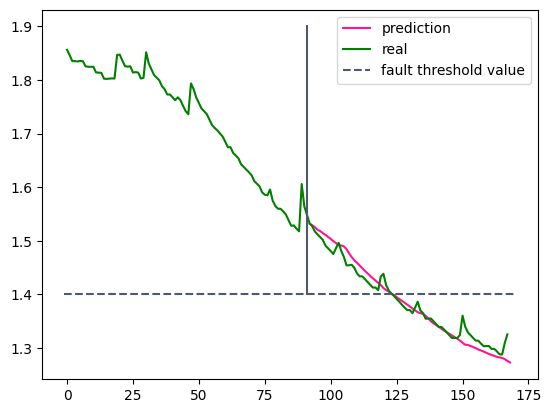

In [62]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [63]:
txt = pred_test.tolist()
txt

[1.5316269397735596,
 1.5288937091827393,
 1.5251586437225342,
 1.5203484296798706,
 1.5179822444915771,
 1.5142037868499756,
 1.5108510255813599,
 1.5070579051971436,
 1.5033832788467407,
 1.4991974830627441,
 1.4954781532287598,
 1.4917820692062378,
 1.491060495376587,
 1.4893550872802734,
 1.4842298030853271,
 1.4761126041412354,
 1.4690730571746826,
 1.4633514881134033,
 1.4586347341537476,
 1.4535834789276123,
 1.4485712051391602,
 1.4434442520141602,
 1.4388676881790161,
 1.4341425895690918,
 1.4296669960021973,
 1.42542564868927,
 1.42146635055542,
 1.4171606302261353,
 1.4115214347839355,
 1.4077924489974976,
 1.405059576034546,
 1.4016385078430176,
 1.3985928297042847,
 1.39470374584198,
 1.3911210298538208,
 1.387746810913086,
 1.3842856884002686,
 1.3807241916656494,
 1.3771100044250488,
 1.373387336730957,
 1.3699723482131958,
 1.3664227724075317,
 1.3646419048309326,
 1.3634240627288818,
 1.359665036201477,
 1.3548588752746582,
 1.3494999408721924,
 1.3456530570983887,
 1.

## BiLSTM

### 30

In [65]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=100
seed=0
train_size=15
mode='BiLSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([15, 1, 16])
epoch:100 | loss:0.0004 | MAE:0.1129 | MSE:0.0149 | RMSE:0.1222 | R2:0.438 


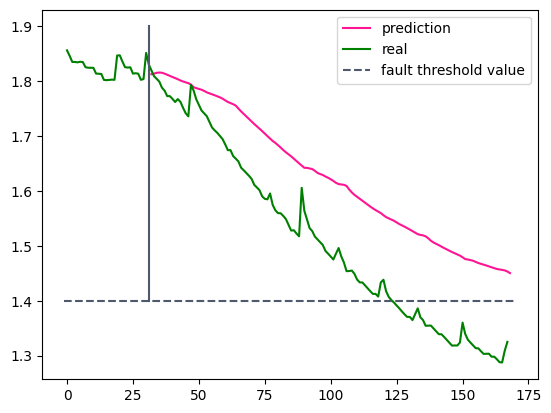

In [66]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [67]:
txt = pred_test.tolist()
txt

[1.813014268875122,
 1.8140629529953003,
 1.8155546188354492,
 1.8159949779510498,
 1.815669059753418,
 1.8139373064041138,
 1.811949610710144,
 1.8097984790802002,
 1.8080008029937744,
 1.8061234951019287,
 1.8038997650146484,
 1.8015408515930176,
 1.7996551990509033,
 1.7982289791107178,
 1.796708583831787,
 1.7940733432769775,
 1.7893162965774536,
 1.7875776290893555,
 1.7861897945404053,
 1.7847766876220703,
 1.7824912071228027,
 1.7798984050750732,
 1.7781600952148438,
 1.7765971422195435,
 1.774570107460022,
 1.772729754447937,
 1.7707865238189697,
 1.768406629562378,
 1.765214204788208,
 1.7623627185821533,
 1.7603319883346558,
 1.7583107948303223,
 1.7557097673416138,
 1.7502963542938232,
 1.7452201843261719,
 1.7405626773834229,
 1.7359176874160767,
 1.7314398288726807,
 1.7268145084381104,
 1.7222073078155518,
 1.7179536819458008,
 1.7136372327804565,
 1.7092714309692383,
 1.7047983407974243,
 1.7001172304153442,
 1.6955389976501465,
 1.6912281513214111,
 1.6877751350402832,


### 60

In [69]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=1700
seed=0
train_size=45
mode='BiLSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([45, 1, 16])
epoch:100 | loss:0.0009 | MAE:0.1072 | MSE:0.0121 | RMSE:0.1102 | R2:0.036 
epoch:200 | loss:0.0009 | MAE:0.1117 | MSE:0.0131 | RMSE:0.1144 | R2:-0.039
epoch:300 | loss:0.0009 | MAE:0.1086 | MSE:0.0123 | RMSE:0.1111 | R2:0.020 
epoch:400 | loss:0.0008 | MAE:0.1047 | MSE:0.0115 | RMSE:0.1071 | R2:0.090 
epoch:500 | loss:0.0008 | MAE:0.1002 | MSE:0.0105 | RMSE:0.1024 | R2:0.167 
epoch:600 | loss:0.0008 | MAE:0.0951 | MSE:0.0094 | RMSE:0.0972 | R2:0.250 
epoch:700 | loss:0.0008 | MAE:0.0895 | MSE:0.0083 | RMSE:0.0914 | R2:0.337 
epoch:800 | loss:0.0008 | MAE:0.0834 | MSE:0.0072 | RMSE:0.0850 | R2:0.426 
epoch:900 | loss:0.0007 | MAE:0.0768 | MSE:0.0061 | RMSE:0.0782 | R2:0.515 
epoch:1000 | loss:0.0007 | MAE:0.0697 | MSE:0.0050 | RMSE:0.0709 | R2:0.601 
epoch:1100 | loss:0.0007 | MAE:0.0622 | MSE:0.0040 | RMSE:0.0633 | R2:0.682 
epoch:1200 | loss:0.0006 | MAE:0.0542 | MSE:0.0031 | RMSE:0.0553 | R2:0.757 
epoch:1300 | loss:0.0006 | MAE:0.0459 | MSE:

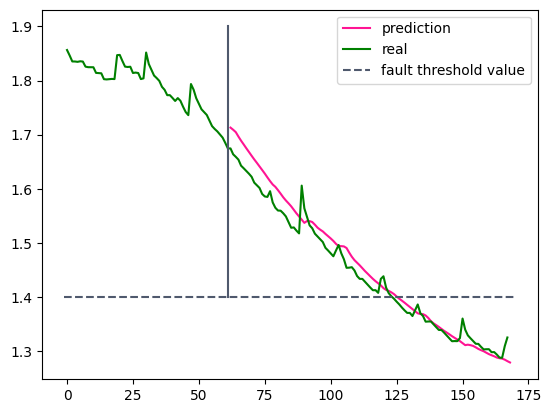

In [70]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [71]:
txt = pred_test.tolist()
txt

[1.7130228281021118,
 1.7090755701065063,
 1.7046611309051514,
 1.6965171098709106,
 1.6888865232467651,
 1.681915283203125,
 1.6747938394546509,
 1.6679497957229614,
 1.661022663116455,
 1.654227614402771,
 1.6478649377822876,
 1.6412752866744995,
 1.6347187757492065,
 1.6280651092529297,
 1.6209522485733032,
 1.6141589879989624,
 1.6079069375991821,
 1.6035549640655518,
 1.597458004951477,
 1.5909768342971802,
 1.5841988325119019,
 1.5783238410949707,
 1.5731018781661987,
 1.5675995349884033,
 1.56112802028656,
 1.5545719861984253,
 1.548784852027893,
 1.5428835153579712,
 1.5369702577590942,
 1.5403631925582886,
 1.540158987045288,
 1.5385136604309082,
 1.5336145162582397,
 1.5281397104263306,
 1.524370789527893,
 1.521165370941162,
 1.5165693759918213,
 1.5123645067214966,
 1.5081560611724854,
 1.503555417060852,
 1.4981619119644165,
 1.4941428899765015,
 1.4939178228378296,
 1.49345862865448,
 1.4904814958572388,
 1.4820679426193237,
 1.4743977785110474,
 1.4680931568145752,
 1.46

### 90

In [73]:
hidden_size = 128
look_back=16
lr=0.001
EPOCH=600
seed=0
train_size=75
mode='BiLSTM'
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size, mode=mode)

train on: cuda:0
torch.Size([75, 1, 16])
epoch:100 | loss:0.0024 | MAE:0.0837 | MSE:0.0073 | RMSE:0.0853 | R2:-0.452
epoch:200 | loss:0.0020 | MAE:0.0758 | MSE:0.0059 | RMSE:0.0771 | R2:-0.188
epoch:300 | loss:0.0016 | MAE:0.0574 | MSE:0.0034 | RMSE:0.0587 | R2:0.311 
epoch:400 | loss:0.0012 | MAE:0.0378 | MSE:0.0016 | RMSE:0.0394 | R2:0.690 
epoch:500 | loss:0.0010 | MAE:0.0203 | MSE:0.0005 | RMSE:0.0221 | R2:0.902 
epoch:600 | loss:0.0008 | MAE:0.0107 | MSE:0.0002 | RMSE:0.0140 | R2:0.961 


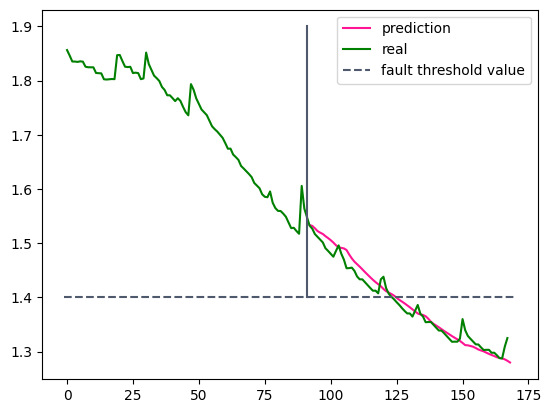

In [74]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [75]:
txt = pred_test.tolist()
txt

[1.533569574356079,
 1.5320327281951904,
 1.5275869369506836,
 1.5225214958190918,
 1.5195329189300537,
 1.5171549320220947,
 1.5130527019500732,
 1.5095622539520264,
 1.5057055950164795,
 1.5012826919555664,
 1.4962738752365112,
 1.4924736022949219,
 1.4915001392364502,
 1.4904813766479492,
 1.487544059753418,
 1.4792556762695312,
 1.4720282554626465,
 1.4660017490386963,
 1.4613544940948486,
 1.4567553997039795,
 1.4518179893493652,
 1.446761131286621,
 1.4419684410095215,
 1.4371891021728516,
 1.4325988292694092,
 1.4283373355865479,
 1.4245237112045288,
 1.4207639694213867,
 1.4156641960144043,
 1.411592721939087,
 1.4090827703475952,
 1.4063671827316284,
 1.403346061706543,
 1.3993630409240723,
 1.3955919742584229,
 1.392467737197876,
 1.389096736907959,
 1.3854899406433105,
 1.381871223449707,
 1.3780531883239746,
 1.3742096424102783,
 1.370455265045166,
 1.3686867952346802,
 1.367720127105713,
 1.365290641784668,
 1.3607947826385498,
 1.3552112579345703,
 1.3512067794799805,
 1.